# Diego Cerretti 2024280040 - Deep Generative Model

# Bernoulli VAE

## Libraries import

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

## Dataset Loading

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")

Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)


## Dataset Preprocessing

In [4]:
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = (x_train > 0.5).astype("float32")
x_test = (x_test > 0.5).astype("float32")

x_train = x_train.reshape(-1, 28 * 28)
x_test = x_test.reshape(-1, 28 * 28)

## Sampling Function

In [5]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Encoder

In [6]:
encoder_inputs = layers.Input(shape=(28 * 28,), name="encoder_input")
x = layers.Dense(256, activation="relu")(encoder_inputs)
z_mean = layers.Dense(40, name="z_mean")(x)
z_log_var = layers.Dense(40, name="z_log_var")(x)
z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])

encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 784)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    200,960 │ encoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 40)        │     10,280 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 40)        │     10,280 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 40)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 221,520 (865.31 KB)

 Trainable params: 221,520 (865.31 KB)

 Non-trainable params: 0 (0.00 B)

## Decoder

In [7]:
decoder_inputs = layers.Input(shape=(40,), name="z_sampling")
x = layers.Dense(256, activation="relu")(decoder_inputs)
decoder_outputs = layers.Dense(28 * 28, activation="sigmoid")(x)

decoder = models.Model(decoder_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)         │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        10,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 784)            │       201,488 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 211,984 (828.06 KB)

 Trainable params: 211,984 (828.06 KB)

 Non-trainable params: 0 (0.00 B)

## VAE

In [31]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        
        reconstruction_loss = tf.keras.backend.binary_crossentropy(inputs, reconstructed)
        reconstruction_loss = tf.reduce_sum(reconstruction_loss, axis=1)
        
        kl_loss = -0.5 * tf.reduce_sum(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
        )

        total_loss = reconstruction_loss + kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        self.add_loss(tf.reduce_mean(total_loss))

        return reconstructed

## VAE Compliation

In [32]:
vae_bernoulli = VAE(encoder, decoder)
vae_bernoulli.compile(optimizer="adam")

## VAE Training

In [33]:
history_bernoulli = vae_bernoulli.fit(
    x_train,
    epochs=30,
    batch_size=128,
    validation_data=(x_test, None)
)

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - kl_loss: 31.3859 - reconstruction_loss: 77.4176 - total_loss: 108.8035 - val_kl_loss: 29.3547 - val_reconstruction_loss: 77.0574 - val_total_loss: 106.4121
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - kl_loss: 29.1350 - reconstruction_loss: 77.2917 - total_loss: 106.4267 - val_kl_loss: 28.5664 - val_reconstruction_loss: 77.0100 - val_total_loss: 105.5763
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - kl_loss: 28.4817 - reconstruction_loss: 77.4575 - total_loss: 105.9392 - val_kl_loss: 28.0874 - val_reconstruction_loss: 77.1867 - val_total_loss: 105.2740
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - kl_loss: 28.1617 - reconstruction_loss: 77.5155 - total_loss: 105.6772 - val_kl_loss: 28.1649 - val_reconstruction_loss: 76.9124 - val_total_loss: 105.0773
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - kl_loss: 27.9543 - reconstruction_loss: 77.5581 - total_loss: 105.5124 - val_kl_loss: 27.4656 - 

## Evaluation and Visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


<Figure size 2000x800 with 0 Axes>

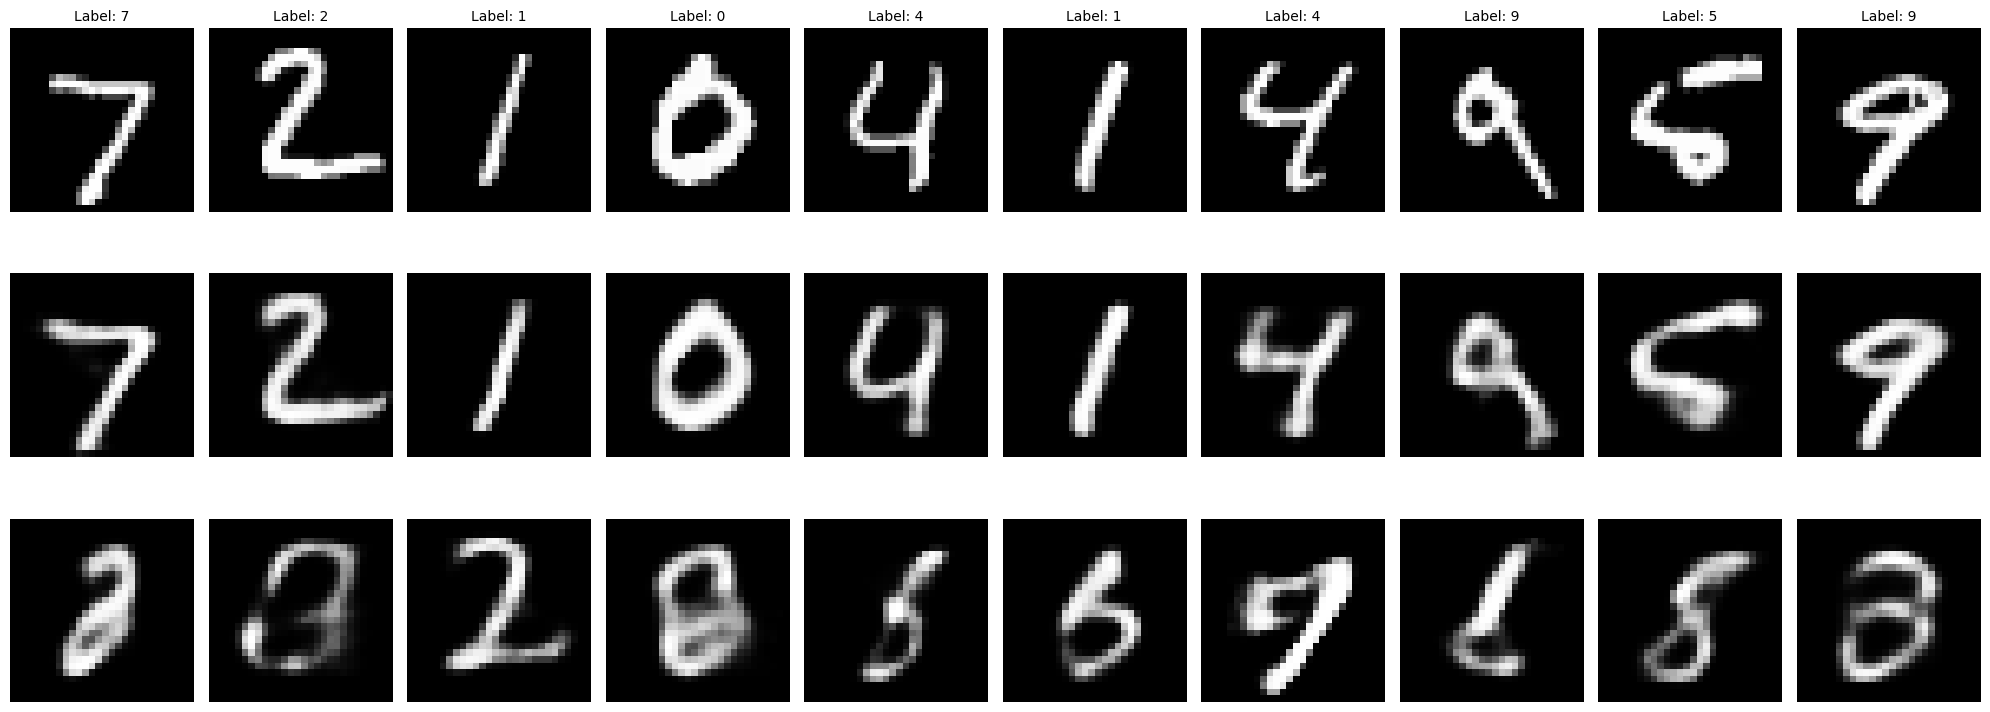

In [34]:
n = 10
decoded_imgs = vae_bernoulli.predict(x_test[:n])
random_latent_vectors = tf.random.normal(shape=(n, 40))
generated_images = vae_bernoulli.decoder.predict(random_latent_vectors)

plt.figure(figsize=(20, 8))  # Increased height to fit 3 rows

plt.figure(figsize=(20, 8))  # Increased height to fit 3 rows

for i in range(n):
    # Original test images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap="gray")  # Test data
    if i == 0:
        plt.ylabel("Test", fontsize=16)
    plt.title(f"Label: {y_test[i]}", fontsize=10)  # Show label for test images
    plt.axis("off")

    # Reconstructed images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap="gray")
    if i == 0:
        plt.ylabel("Reconstructed", fontsize=16)
    plt.axis("off")

    # Generated images
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(generated_images[i].reshape(28, 28), cmap="gray")
    if i == 0:
        plt.ylabel("Generated", fontsize=16)
    plt.axis("off")

plt.tight_layout()
plt.show()

# Gaussian VAE

## Dataset Loading

In [35]:
np.random.seed(42)
tf.random.set_seed(42)
(x_train_original, y_train), (x_test_original, y_test) = tf.keras.datasets.mnist.load_data()

print(f"Training data shape: {x_train_original.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {x_test_original.shape}")
print(f"Test labels shape: {y_test.shape}")

Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)


## Dataset Preprocessing

In [36]:
x_train = x_train_original.astype("float32") / 255.0
x_test = x_test_original.astype("float32") / 255.0

x_train = x_train.reshape(-1, 28 * 28)
x_test = x_test.reshape(-1, 28 * 28)

## Sampling

In [37]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Encoder

In [38]:
encoder_inputs = layers.Input(shape=(28 * 28,), name="encoder_input")
x = layers.Dense(256, activation="relu")(encoder_inputs)
z_mean = layers.Dense(40, name="z_mean")(x)
z_log_var = layers.Dense(40, name="z_log_var")(x)
z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])

encoder_gaussian = models.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder_gaussian")
encoder_gaussian.summary()

Model: "encoder_gaussian"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 784)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │    200,960 │ encoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 40)        │     10,280 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 40)        │     10,280 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 40)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 221,520 (865.31 KB)

 Trainable params: 221,520 (865.31 KB)

 Non-trainable params: 0 (0.00 B)

## Decoder

In [39]:
decoder_inputs = layers.Input(shape=(40,), name="z_sampling")
x = layers.Dense(256, activation="relu")(decoder_inputs)
decoder_outputs = layers.Dense(28 * 28, activation="linear")(x)

decoder_gaussian = models.Model(decoder_inputs, decoder_outputs, name="decoder_gaussian")
decoder_gaussian.summary()

Model: "decoder_gaussian"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)         │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        10,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 784)            │       201,488 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 211,984 (828.06 KB)

 Trainable params: 211,984 (828.06 KB)

 Non-trainable params: 0 (0.00 B)

## VAE Adjustment

In [40]:
class VAE_Gaussian(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE_Gaussian, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)

        reconstruction_loss = tf.reduce_sum(tf.square(inputs - reconstructed), axis=1)
        kl_loss = -0.5 * tf.reduce_sum(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
        )

        total_loss = reconstruction_loss + kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        self.add_loss(tf.reduce_mean(total_loss))

        return reconstructed
    
vae_gaussian = VAE_Gaussian(encoder_gaussian, decoder_gaussian)
vae_gaussian.compile(optimizer="adam")

## Training

In [41]:
history_gaussian = vae_gaussian.fit(
    x_train,
    epochs=30,
    batch_size=128,
    validation_data=(x_test, None)
)

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - kl_loss: 5.4149 - reconstruction_loss: 52.8118 - total_loss: 58.2267 - val_kl_loss: 8.9831 - val_reconstruction_loss: 29.7770 - val_total_loss: 38.7601
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - kl_loss: 8.9744 - reconstruction_loss: 28.8142 - total_loss: 37.7885 - val_kl_loss: 9.5124 - val_reconstruction_loss: 25.9355 - val_total_loss: 35.4479
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - kl_loss: 9.5845 - reconstruction_loss: 25.8780 - total_loss: 35.4625 - val_kl_loss: 10.0919 - val_reconstruction_loss: 24.3868 - val_total_loss: 34.4786
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - kl_loss: 9.9359 - reconstruction_loss: 24.6500 - total_loss: 34.5859 - val_kl_loss: 10.2747 - val_reconstruction_loss: 23.6257 - val_total_loss: 33.9004
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - kl_loss: 10.1208 - reconstruction_loss: 23.9861 - total_loss: 34.1068 - val_kl_loss: 10.4035 - val_reconstruction_

## Evaluation and Visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


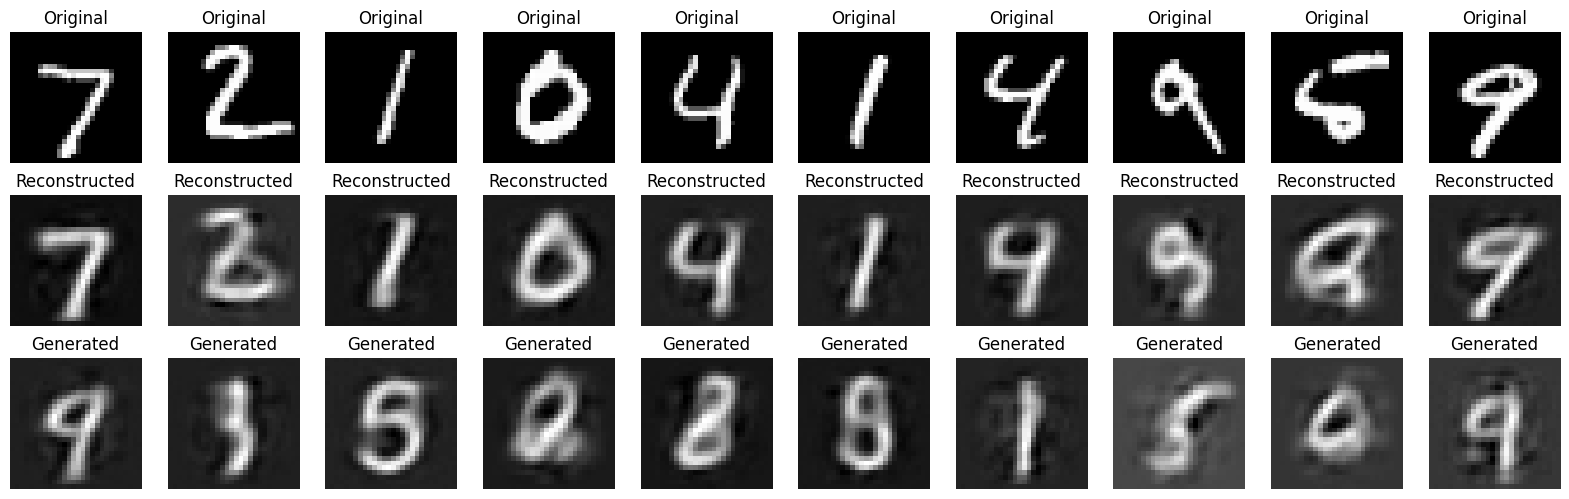

In [42]:
decoded_imgs_gaussian = vae_gaussian.predict(x_test[:10])

n_samples = 10
random_latent_vectors = tf.random.normal(shape=(n_samples, 40))
generated_images_gaussian = vae_gaussian.decoder.predict(random_latent_vectors)

n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs_gaussian[i].reshape(28, 28), cmap="gray")
    plt.title("Reconstructed")
    plt.axis("off")
    
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(generated_images_gaussian[i].reshape(28, 28), cmap='gray')
    plt.title("Generated")
    plt.axis("off")

plt.show()

## Bernoulli vs Gaussian Comparison

## Reconstruction

In [43]:
reconstructed_bernoulli = vae_bernoulli.predict(x_test)
reconstruction_error_bernoulli = np.mean(
    tf.keras.losses.binary_crossentropy(x_test, reconstructed_bernoulli).numpy()
)

reconstructed_gaussian = vae_gaussian.predict(x_test)
reconstruction_error_gaussian = np.mean(
    np.mean(np.square(x_test - reconstructed_gaussian), axis=1)
)

print(f"Reconstruction Error (Bernoulli VAE): {reconstruction_error_bernoulli:.4f}")
print(f"Reconstruction Error (Gaussian VAE): {reconstruction_error_gaussian:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Reconstruction Error (Bernoulli VAE): 0.0976
Reconstruction Error (Gaussian VAE): 0.0256


## Generation

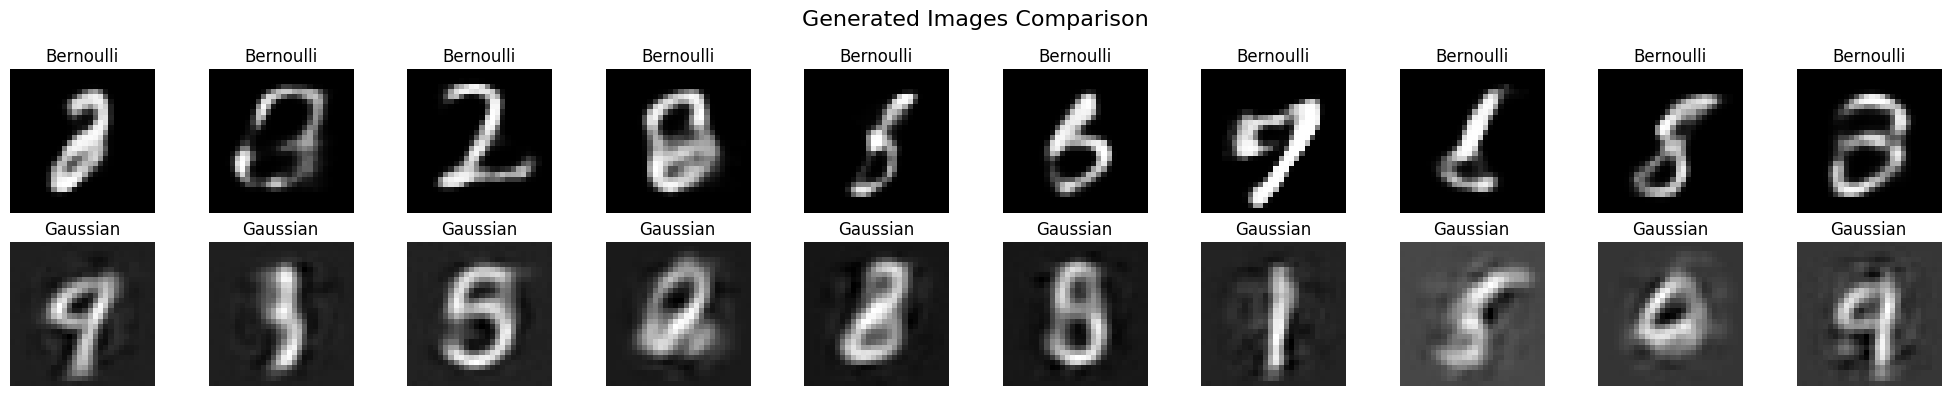

In [44]:
# Visualize generated images side by side for comparison
plt.figure(figsize=(20, 4))
for i in range(n_samples):
    # Bernoulli VAE
    ax = plt.subplot(2, n_samples, i + 1)
    plt.imshow(generated_images[i].reshape(28, 28), cmap="gray")
    plt.title("Bernoulli")
    plt.axis("off")
    
    # Gaussian VAE
    ax = plt.subplot(2, n_samples, i + 1 + n_samples)
    plt.imshow(generated_images_gaussian[i].reshape(28, 28), cmap="gray")
    plt.title("Gaussian")
    plt.axis("off")
plt.suptitle("Generated Images Comparison", fontsize=16)
plt.tight_layout()
plt.show()

## Latent Space Structure

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


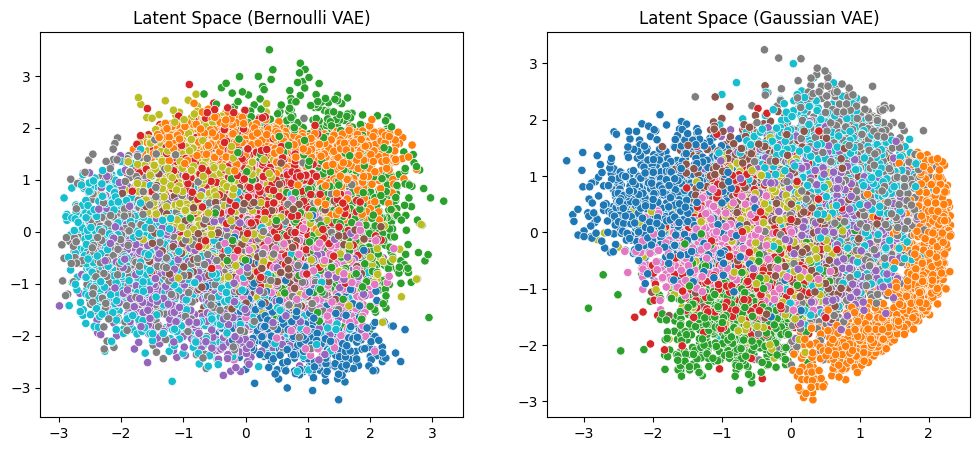

In [45]:
from sklearn.decomposition import PCA
import seaborn as sns

z_mean_bernoulli, _, _ = vae_bernoulli.encoder.predict(x_test)
z_mean_gaussian, _, _ = vae_gaussian.encoder.predict(x_test)

pca_bernoulli = PCA(n_components=2).fit_transform(z_mean_bernoulli)
pca_gaussian = PCA(n_components=2).fit_transform(z_mean_gaussian)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=pca_bernoulli[:, 0], y=pca_bernoulli[:, 1], hue=y_test, palette="tab10", legend=None)
plt.title("Latent Space (Bernoulli VAE)")

plt.subplot(1, 2, 2)
sns.scatterplot(x=pca_gaussian[:, 0], y=pca_gaussian[:, 1], hue=y_test, palette="tab10", legend=None)
plt.title("Latent Space (Gaussian VAE)")
plt.show()


## Diversity

In [46]:
diversity_bernoulli = np.var(generated_images, axis=0).mean()
diversity_gaussian = np.var(generated_images_gaussian, axis=0).mean()

print(f"Diversity (Bernoulli VAE): {diversity_bernoulli:.4f}")
print(f"Diversity (Gaussian VAE): {diversity_gaussian:.4f}")

Diversity (Bernoulli VAE): 0.0357
Diversity (Gaussian VAE): 0.0230
